In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Car_number/data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/23824.jpg    
  inflating: data/train/23825.bmp    
  inflating: data/train/23826.jpg    
  inflating: data/train/23827.bmp    
  inflating: data/train/23828.jpg    
  inflating: data/train/23829.jpg    
  inflating: data/train/23830.bmp    
  inflating: data/train/23831.bmp    
  inflating: data/train/23832.bmp    
  inflating: data/train/23833.jpg    
  inflating: data/train/23834.bmp    
  inflating: data/train/23835.jpg    
  inflating: data/train/23836.jpg    
  inflating: data/train/23837.jpg    
  inflating: data/train/23838.bmp    
  inflating: data/train/23839.bmp    
  inflating: data/train/23840.jpg    
  inflating: data/train/23841.jpg    
  inflating: data/train/23842.jpg    
  inflating: data/train/23843.bmp    
  inflating: data/train/23844.bmp    
  inflating: data/train/23845.jpg    
  inflating: data/train/23846.jpg    
  inflating: data/train/23847.jpg    
  inflating: data/tr

In [ ]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [ ]:
#функция взята для ROI
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped


def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    
        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [ ]:
#апроксимация полученной маски до четырехуголника
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

In [ ]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.1
VAL_SIZE = 0.01
TEST_SIZE = 0.01
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
val_end = test_start + int(VAL_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:val_end]

test_marks = all_marks[val_end:val_end+int(TEST_SIZE * len(all_marks))]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

In [ ]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            

            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=2,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=2,
    collate_fn=collate_fn, 
)


In [ ]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
device

device(type='cuda')

In [ ]:
model 

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

loss_test_list = np.zeros((4,))
batch_losses = np.zeros((4,))
for epoch in range(4):
    model.train()
    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())
        loss_test_list[epoch] = losses.item()


        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = []


    for images, targets in tqdm.tqdm(val_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        batch_losses[epoch] = losses.item()
        optimizer.zero_grad()
    





  0%|          | 0/1281 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss: 0.9449770


  3%|▎         | 40/1281 [00:46<23:54,  1.16s/it]

Loss: 0.5254267


  5%|▍         | 60/1281 [01:10<24:10,  1.19s/it]

Loss: 0.3969147


  6%|▌         | 80/1281 [01:33<22:03,  1.10s/it]

Loss: 0.3391347


  8%|▊         | 100/1281 [01:55<21:54,  1.11s/it]

Loss: 0.3110766


  9%|▉         | 120/1281 [02:18<23:18,  1.20s/it]

Loss: 0.2524200


 11%|█         | 140/1281 [02:40<21:06,  1.11s/it]

Loss: 0.2768864


 12%|█▏        | 160/1281 [03:02<19:56,  1.07s/it]

Loss: 0.2414555


 14%|█▍        | 180/1281 [03:25<21:48,  1.19s/it]

Loss: 0.2761347


 16%|█▌        | 200/1281 [03:47<19:46,  1.10s/it]

Loss: 0.2620026


 17%|█▋        | 220/1281 [04:08<18:55,  1.07s/it]

Loss: 0.2006923


 19%|█▊        | 240/1281 [04:31<19:58,  1.15s/it]

Loss: 0.2111060


 20%|██        | 260/1281 [04:53<18:50,  1.11s/it]

Loss: 0.2239689


 22%|██▏       | 280/1281 [05:15<17:49,  1.07s/it]

Loss: 0.2314101


 23%|██▎       | 300/1281 [05:37<17:49,  1.09s/it]

Loss: 0.2019713


 25%|██▍       | 320/1281 [05:59<17:24,  1.09s/it]

Loss: 0.2164353


 27%|██▋       | 340/1281 [06:22<17:42,  1.13s/it]

Loss: 0.2317810


 28%|██▊       | 360/1281 [06:44<17:21,  1.13s/it]

Loss: 0.2237970


 30%|██▉       | 380/1281 [07:06<16:13,  1.08s/it]

Loss: 0.2203247


 31%|███       | 400/1281 [07:28<16:15,  1.11s/it]

Loss: 0.2132294


 33%|███▎      | 420/1281 [07:50<15:46,  1.10s/it]

Loss: 0.2173320


 34%|███▍      | 440/1281 [08:12<15:22,  1.10s/it]

Loss: 0.2211555


 36%|███▌      | 460/1281 [08:35<15:27,  1.13s/it]

Loss: 0.2141387


 37%|███▋      | 480/1281 [08:57<14:59,  1.12s/it]

Loss: 0.2542643


 39%|███▉      | 500/1281 [09:20<14:16,  1.10s/it]

Loss: 0.2151126


 41%|████      | 520/1281 [09:43<13:43,  1.08s/it]

Loss: 0.2461279


 42%|████▏     | 540/1281 [10:05<14:04,  1.14s/it]

Loss: 0.2428267


 44%|████▎     | 560/1281 [10:28<13:36,  1.13s/it]

Loss: 0.2346529


 45%|████▌     | 580/1281 [10:50<13:07,  1.12s/it]

Loss: 0.2384968


 47%|████▋     | 600/1281 [11:12<12:46,  1.12s/it]

Loss: 0.2232840


 48%|████▊     | 620/1281 [11:34<12:03,  1.09s/it]

Loss: 0.2313961


 50%|████▉     | 640/1281 [11:56<11:41,  1.10s/it]

Loss: 0.2313643
Epoch    32: reducing learning rate of group 0 to 1.5000e-04.


 52%|█████▏    | 660/1281 [12:19<11:44,  1.13s/it]

Loss: 0.2083619


 53%|█████▎    | 680/1281 [12:41<10:25,  1.04s/it]

Loss: 0.2025569


 55%|█████▍    | 700/1281 [13:03<10:24,  1.07s/it]

Loss: 0.1911236


 56%|█████▌    | 720/1281 [13:25<10:35,  1.13s/it]

Loss: 0.1709484


 58%|█████▊    | 740/1281 [13:47<09:53,  1.10s/it]

Loss: 0.2043741


 59%|█████▉    | 760/1281 [14:09<09:37,  1.11s/it]

Loss: 0.2079488


 61%|██████    | 780/1281 [14:31<08:52,  1.06s/it]

Loss: 0.1951257


 62%|██████▏   | 800/1281 [14:53<09:02,  1.13s/it]

Loss: 0.2178617


 64%|██████▍   | 820/1281 [15:16<08:33,  1.11s/it]

Loss: 0.2240469


 66%|██████▌   | 840/1281 [15:39<07:52,  1.07s/it]

Loss: 0.2031020


 67%|██████▋   | 860/1281 [16:00<07:34,  1.08s/it]

Loss: 0.1838846


 69%|██████▊   | 880/1281 [16:23<07:27,  1.12s/it]

Loss: 0.1976623


 70%|███████   | 900/1281 [16:45<06:43,  1.06s/it]

Loss: 0.1588130


 72%|███████▏  | 920/1281 [17:07<06:30,  1.08s/it]

Loss: 0.1905862


 73%|███████▎  | 940/1281 [17:29<06:32,  1.15s/it]

Loss: 0.1898922


 75%|███████▍  | 960/1281 [17:53<06:04,  1.14s/it]

Loss: 0.2015611


 77%|███████▋  | 980/1281 [18:16<05:32,  1.10s/it]

Loss: 0.1883054


 78%|███████▊  | 1000/1281 [18:39<05:26,  1.16s/it]

Loss: 0.1766639


 80%|███████▉  | 1020/1281 [19:01<04:48,  1.10s/it]

Loss: 0.2054888


 81%|████████  | 1040/1281 [19:25<04:36,  1.15s/it]

Loss: 0.2065164


 83%|████████▎ | 1060/1281 [19:47<03:56,  1.07s/it]

Loss: 0.1928057


 84%|████████▍ | 1080/1281 [20:09<03:37,  1.08s/it]

Loss: 0.1803125


 86%|████████▌ | 1100/1281 [20:31<03:15,  1.08s/it]

Loss: 0.1675741


 87%|████████▋ | 1120/1281 [20:54<02:57,  1.10s/it]

Loss: 0.1789107


 89%|████████▉ | 1140/1281 [21:17<02:41,  1.14s/it]

Loss: 0.1884009


 91%|█████████ | 1160/1281 [21:39<02:13,  1.10s/it]

Loss: 0.1924565


 92%|█████████▏| 1180/1281 [22:02<02:04,  1.23s/it]

Loss: 0.1917883


 94%|█████████▎| 1200/1281 [22:26<01:33,  1.16s/it]

Loss: 0.1942315


 95%|█████████▌| 1220/1281 [22:48<01:09,  1.14s/it]

Loss: 0.2022965


 97%|█████████▋| 1240/1281 [23:10<00:43,  1.07s/it]

Loss: 0.1995436


 98%|█████████▊| 1260/1281 [23:32<00:23,  1.10s/it]

Loss: 0.1770329


100%|█████████▉| 1280/1281 [23:54<00:01,  1.13s/it]

Loss: 0.1823903


  0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  0%|          | 0/1281 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered inter

Loss: 0.2060801


  3%|▎         | 40/1281 [00:45<23:15,  1.12s/it]

Loss: 0.1889399
Epoch    66: reducing learning rate of group 0 to 7.5000e-05.


  5%|▍         | 60/1281 [01:09<24:18,  1.19s/it]

Loss: 0.1905440


  6%|▌         | 80/1281 [01:32<22:15,  1.11s/it]

Loss: 0.1916613


  8%|▊         | 100/1281 [01:55<22:02,  1.12s/it]

Loss: 0.1964436


  9%|▉         | 120/1281 [02:17<22:00,  1.14s/it]

Loss: 0.1763441


 11%|█         | 140/1281 [02:40<21:02,  1.11s/it]

Loss: 0.1776527


 12%|█▏        | 160/1281 [03:01<20:19,  1.09s/it]

Loss: 0.1701959


 14%|█▍        | 180/1281 [03:24<21:44,  1.18s/it]

Loss: 0.1920022


 16%|█▌        | 200/1281 [03:46<19:56,  1.11s/it]

Loss: 0.1798346


 17%|█▋        | 220/1281 [04:08<19:15,  1.09s/it]

Loss: 0.1440837


 19%|█▊        | 240/1281 [04:31<19:46,  1.14s/it]

Loss: 0.1661586


 20%|██        | 260/1281 [04:53<18:57,  1.11s/it]

Loss: 0.1593588


 22%|██▏       | 280/1281 [05:15<18:05,  1.08s/it]

Loss: 0.1772302


 23%|██▎       | 300/1281 [05:37<18:09,  1.11s/it]

Loss: 0.1610813


 25%|██▍       | 320/1281 [05:59<17:17,  1.08s/it]

Loss: 0.1700982


 27%|██▋       | 340/1281 [06:22<17:42,  1.13s/it]

Loss: 0.1727927


 28%|██▊       | 360/1281 [06:44<17:17,  1.13s/it]

Loss: 0.1672734


 30%|██▉       | 380/1281 [07:06<16:13,  1.08s/it]

Loss: 0.1519179


 31%|███       | 400/1281 [07:28<16:12,  1.10s/it]

Loss: 0.1558315


 33%|███▎      | 420/1281 [07:51<15:42,  1.09s/it]

Loss: 0.1655220


 34%|███▍      | 440/1281 [08:12<15:27,  1.10s/it]

Loss: 0.1570063


 36%|███▌      | 460/1281 [08:35<15:17,  1.12s/it]

Loss: 0.1541579


 37%|███▋      | 480/1281 [08:57<14:37,  1.10s/it]

Loss: 0.2099191


 39%|███▉      | 500/1281 [09:19<13:55,  1.07s/it]

Loss: 0.1578666


 41%|████      | 520/1281 [09:42<13:44,  1.08s/it]

Loss: 0.1710311


 42%|████▏     | 540/1281 [10:04<13:56,  1.13s/it]

Loss: 0.1721302


 44%|████▎     | 560/1281 [10:26<13:12,  1.10s/it]

Loss: 0.1552374


 45%|████▌     | 580/1281 [10:48<13:03,  1.12s/it]

Loss: 0.1707732


 47%|████▋     | 600/1281 [11:11<12:54,  1.14s/it]

Loss: 0.1620260


 48%|████▊     | 620/1281 [11:33<12:10,  1.11s/it]

Loss: 0.1817426


 50%|████▉     | 640/1281 [11:55<11:45,  1.10s/it]

Loss: 0.1882517
Epoch    96: reducing learning rate of group 0 to 3.7500e-05.


 52%|█████▏    | 660/1281 [12:17<11:46,  1.14s/it]

Loss: 0.1667107


 53%|█████▎    | 680/1281 [12:40<10:32,  1.05s/it]

Loss: 0.1623380


 55%|█████▍    | 700/1281 [13:01<10:29,  1.08s/it]

Loss: 0.1640076


 56%|█████▌    | 720/1281 [13:23<10:39,  1.14s/it]

Loss: 0.1494673


 58%|█████▊    | 740/1281 [13:46<09:58,  1.11s/it]

Loss: 0.1670263


 59%|█████▉    | 760/1281 [14:08<09:44,  1.12s/it]

Loss: 0.1841296


 61%|██████    | 780/1281 [14:29<08:52,  1.06s/it]

Loss: 0.1637261


 62%|██████▏   | 800/1281 [14:52<09:04,  1.13s/it]

Loss: 0.1737321


 64%|██████▍   | 820/1281 [15:15<08:32,  1.11s/it]

Loss: 0.1958147


 66%|██████▌   | 840/1281 [15:37<07:46,  1.06s/it]

Loss: 0.1705975


 67%|██████▋   | 860/1281 [15:59<07:33,  1.08s/it]

Loss: 0.1547698


 69%|██████▊   | 880/1281 [16:21<07:21,  1.10s/it]

Loss: 0.1703304


 70%|███████   | 900/1281 [16:43<06:47,  1.07s/it]

Loss: 0.1361709


 72%|███████▏  | 920/1281 [17:05<06:33,  1.09s/it]

Loss: 0.1610391


 73%|███████▎  | 940/1281 [17:27<06:21,  1.12s/it]

Loss: 0.1692317


 75%|███████▍  | 960/1281 [17:50<06:04,  1.14s/it]

Loss: 0.1622629


 77%|███████▋  | 980/1281 [18:12<05:20,  1.07s/it]

Loss: 0.1585221


 78%|███████▊  | 1000/1281 [18:35<05:24,  1.15s/it]

Loss: 0.1434143


 80%|███████▉  | 1020/1281 [18:57<04:45,  1.10s/it]

Loss: 0.1632326


 81%|████████  | 1040/1281 [19:21<04:39,  1.16s/it]

Loss: 0.1616756


 83%|████████▎ | 1060/1281 [19:43<03:57,  1.08s/it]

Loss: 0.1656575


 84%|████████▍ | 1080/1281 [20:05<03:37,  1.08s/it]

Loss: 0.1528308


 86%|████████▌ | 1100/1281 [20:27<03:18,  1.09s/it]

Loss: 0.1459732


 87%|████████▋ | 1120/1281 [20:50<03:04,  1.14s/it]

Loss: 0.1446408


 89%|████████▉ | 1140/1281 [21:13<02:35,  1.10s/it]

Loss: 0.1662411


 91%|█████████ | 1160/1281 [21:35<02:10,  1.08s/it]

Loss: 0.1647483


 92%|█████████▏| 1180/1281 [21:57<01:54,  1.13s/it]

Loss: 0.1651506


 94%|█████████▎| 1200/1281 [22:20<01:33,  1.16s/it]

Loss: 0.1516436


 95%|█████████▌| 1220/1281 [22:42<01:09,  1.15s/it]

Loss: 0.1675356


 97%|█████████▋| 1240/1281 [23:04<00:44,  1.09s/it]

Loss: 0.1677926


 98%|█████████▊| 1260/1281 [23:27<00:23,  1.10s/it]

Loss: 0.1547020


100%|█████████▉| 1280/1281 [23:49<00:01,  1.13s/it]

Loss: 0.1587802


  0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  0%|          | 0/1281 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered inter

Loss: 0.1732851


  3%|▎         | 40/1281 [00:45<22:51,  1.11s/it]

Loss: 0.1657524
Epoch   130: reducing learning rate of group 0 to 1.8750e-05.


  5%|▍         | 60/1281 [01:09<24:15,  1.19s/it]

Loss: 0.1706567


  6%|▌         | 80/1281 [01:32<22:12,  1.11s/it]

Loss: 0.1736945


  8%|▊         | 100/1281 [01:54<21:49,  1.11s/it]

Loss: 0.1758779


  9%|▉         | 120/1281 [02:17<21:47,  1.13s/it]

Loss: 0.1582407


 11%|█         | 140/1281 [02:39<20:58,  1.10s/it]

Loss: 0.1540211


 12%|█▏        | 160/1281 [03:01<20:15,  1.08s/it]

Loss: 0.1529233


 14%|█▍        | 180/1281 [03:24<21:50,  1.19s/it]

Loss: 0.1712555


 16%|█▌        | 200/1281 [03:46<19:55,  1.11s/it]

Loss: 0.1620753


 17%|█▋        | 220/1281 [04:07<18:59,  1.07s/it]

Loss: 0.1356072


 19%|█▊        | 240/1281 [04:30<19:41,  1.14s/it]

Loss: 0.1502996


 20%|██        | 260/1281 [04:52<18:54,  1.11s/it]

Loss: 0.1438888


 22%|██▏       | 280/1281 [05:14<17:55,  1.07s/it]

Loss: 0.1624928


 23%|██▎       | 300/1281 [05:36<17:52,  1.09s/it]

Loss: 0.1433699


 25%|██▍       | 320/1281 [05:58<17:20,  1.08s/it]

Loss: 0.1496621


 27%|██▋       | 340/1281 [06:21<17:52,  1.14s/it]

Loss: 0.1582110


 28%|██▊       | 360/1281 [06:43<17:08,  1.12s/it]

Loss: 0.1529616


 30%|██▉       | 380/1281 [07:05<16:07,  1.07s/it]

Loss: 0.1431155


 31%|███       | 400/1281 [07:27<16:11,  1.10s/it]

Loss: 0.1411166


 33%|███▎      | 420/1281 [07:50<15:49,  1.10s/it]

Loss: 0.1465809


 34%|███▍      | 440/1281 [08:11<15:32,  1.11s/it]

Loss: 0.1433083


 36%|███▌      | 460/1281 [08:34<15:22,  1.12s/it]

Loss: 0.1382781


 37%|███▋      | 480/1281 [08:56<14:41,  1.10s/it]

Loss: 0.1884725


 39%|███▉      | 500/1281 [09:18<14:03,  1.08s/it]

Loss: 0.1377973


 41%|████      | 520/1281 [09:41<13:39,  1.08s/it]

Loss: 0.1522879


 42%|████▏     | 540/1281 [10:03<14:04,  1.14s/it]

Loss: 0.1555403


 44%|████▎     | 560/1281 [10:25<13:07,  1.09s/it]

Loss: 0.1353391


 45%|████▌     | 580/1281 [10:47<12:55,  1.11s/it]

Loss: 0.1454018


 47%|████▋     | 600/1281 [11:10<12:48,  1.13s/it]

Loss: 0.1429406


 48%|████▊     | 620/1281 [11:32<12:03,  1.09s/it]

Loss: 0.1659827


 50%|████▉     | 640/1281 [11:54<11:44,  1.10s/it]

Loss: 0.1658918


 52%|█████▏    | 660/1281 [12:16<11:47,  1.14s/it]

Loss: 0.1535791


 53%|█████▎    | 680/1281 [12:38<10:34,  1.06s/it]

Loss: 0.1491989


 55%|█████▍    | 700/1281 [13:00<10:29,  1.08s/it]

Loss: 0.1551305


 56%|█████▌    | 720/1281 [13:22<10:39,  1.14s/it]

Loss: 0.1379609


 58%|█████▊    | 740/1281 [13:45<09:58,  1.11s/it]

Loss: 0.1568644


 59%|█████▉    | 760/1281 [14:07<09:42,  1.12s/it]

Loss: 0.1747897


 61%|██████    | 780/1281 [14:28<08:50,  1.06s/it]

Loss: 0.1532151


 62%|██████▏   | 800/1281 [14:51<09:01,  1.13s/it]

Loss: 0.1623348


 64%|██████▍   | 820/1281 [15:13<08:35,  1.12s/it]

Loss: 0.1807710


 66%|██████▌   | 840/1281 [15:35<07:47,  1.06s/it]

Loss: 0.1568190


 67%|██████▋   | 860/1281 [15:57<07:35,  1.08s/it]

Loss: 0.1427126


 69%|██████▊   | 880/1281 [16:20<07:20,  1.10s/it]

Loss: 0.1603748


 70%|███████   | 900/1281 [16:42<06:48,  1.07s/it]

Loss: 0.1299931


 72%|███████▏  | 920/1281 [17:04<06:31,  1.08s/it]

Loss: 0.1539147


 73%|███████▎  | 940/1281 [17:26<06:18,  1.11s/it]

Loss: 0.1586716


 75%|███████▍  | 960/1281 [17:48<06:04,  1.14s/it]

Loss: 0.1560358


 77%|███████▋  | 980/1281 [18:11<05:21,  1.07s/it]

Loss: 0.1469336


 78%|███████▊  | 1000/1281 [18:33<05:22,  1.15s/it]

Loss: 0.1342424


 80%|███████▉  | 1020/1281 [18:55<04:44,  1.09s/it]

Loss: 0.1508560


 81%|████████  | 1040/1281 [19:19<04:40,  1.16s/it]

Loss: 0.1513948


 83%|████████▎ | 1060/1281 [19:41<03:57,  1.08s/it]

Loss: 0.1498001


 84%|████████▍ | 1080/1281 [20:03<03:36,  1.08s/it]

Loss: 0.1394066


 86%|████████▌ | 1100/1281 [20:25<03:17,  1.09s/it]

Loss: 0.1367913


 87%|████████▋ | 1120/1281 [20:48<03:02,  1.13s/it]

Loss: 0.1382626


 89%|████████▉ | 1140/1281 [21:11<02:35,  1.10s/it]

Loss: 0.1545100


 91%|█████████ | 1160/1281 [21:33<02:10,  1.08s/it]

Loss: 0.1511480


 92%|█████████▏| 1180/1281 [21:55<01:54,  1.13s/it]

Loss: 0.1532835


 94%|█████████▎| 1200/1281 [22:18<01:33,  1.16s/it]

Loss: 0.1430718


 95%|█████████▌| 1220/1281 [22:41<01:09,  1.14s/it]

Loss: 0.1543295


 97%|█████████▋| 1240/1281 [23:02<00:43,  1.07s/it]

Loss: 0.1581239


 98%|█████████▊| 1260/1281 [23:25<00:23,  1.11s/it]

Loss: 0.1448558


100%|█████████▉| 1280/1281 [23:47<00:01,  1.14s/it]

Loss: 0.1476031


  0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  0%|          | 0/1281 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered inter

Loss: 0.1658218


  3%|▎         | 40/1281 [00:45<23:16,  1.13s/it]

Loss: 0.1553107
Epoch   194: reducing learning rate of group 0 to 9.3750e-06.


  5%|▍         | 60/1281 [01:09<23:57,  1.18s/it]

Loss: 0.1669750


  6%|▌         | 80/1281 [01:32<22:17,  1.11s/it]

Loss: 0.1669556


  8%|▊         | 100/1281 [01:54<21:57,  1.12s/it]

Loss: 0.1650092


  9%|▉         | 120/1281 [02:17<21:48,  1.13s/it]

Loss: 0.1539391


 11%|█         | 140/1281 [02:39<21:01,  1.11s/it]

Loss: 0.1423478


 12%|█▏        | 160/1281 [03:01<20:15,  1.08s/it]

Loss: 0.1422079


 14%|█▍        | 180/1281 [03:24<21:41,  1.18s/it]

Loss: 0.1621102


 16%|█▌        | 200/1281 [03:46<19:58,  1.11s/it]

Loss: 0.1543295


 17%|█▋        | 220/1281 [04:08<19:04,  1.08s/it]

Loss: 0.1319911


 19%|█▊        | 240/1281 [04:31<19:48,  1.14s/it]

Loss: 0.1466117


 20%|██        | 260/1281 [04:53<18:58,  1.12s/it]

Loss: 0.1381105


 22%|██▏       | 280/1281 [05:15<18:02,  1.08s/it]

Loss: 0.1617711


 23%|██▎       | 300/1281 [05:37<18:19,  1.12s/it]

Loss: 0.1391522


 25%|██▍       | 320/1281 [05:59<17:19,  1.08s/it]

Loss: 0.1466324


 27%|██▋       | 340/1281 [06:21<17:40,  1.13s/it]

Loss: 0.1466101


 28%|██▊       | 360/1281 [06:44<17:09,  1.12s/it]

Loss: 0.1459990


 30%|██▉       | 380/1281 [07:06<16:16,  1.08s/it]

Loss: 0.1394222


 31%|███       | 400/1281 [07:28<16:14,  1.11s/it]

Loss: 0.1386126


 33%|███▎      | 420/1281 [07:50<15:52,  1.11s/it]

Loss: 0.1423361


 34%|███▍      | 440/1281 [08:12<15:35,  1.11s/it]

Loss: 0.1394387


 36%|███▌      | 460/1281 [08:35<15:29,  1.13s/it]

Loss: 0.1330080
Epoch   215: reducing learning rate of group 0 to 4.6875e-06.


 37%|███▋      | 480/1281 [08:57<14:38,  1.10s/it]

Loss: 0.1818266


 39%|███▉      | 500/1281 [09:19<13:55,  1.07s/it]

Loss: 0.1314412


 41%|████      | 520/1281 [09:42<13:49,  1.09s/it]

Loss: 0.1462376


 42%|████▏     | 540/1281 [10:04<13:59,  1.13s/it]

Loss: 0.1526470


 44%|████▎     | 560/1281 [10:26<13:08,  1.09s/it]

Loss: 0.1306707


 45%|████▌     | 580/1281 [10:48<12:59,  1.11s/it]

Loss: 0.1428976


 47%|████▋     | 600/1281 [11:10<12:45,  1.12s/it]

Loss: 0.1366597


 48%|████▊     | 620/1281 [11:33<12:09,  1.10s/it]

Loss: 0.1612959


 50%|████▉     | 640/1281 [11:55<11:52,  1.11s/it]

Loss: 0.1556054


 52%|█████▏    | 660/1281 [12:17<11:47,  1.14s/it]

Loss: 0.1455351


 53%|█████▎    | 680/1281 [12:39<10:27,  1.04s/it]

Loss: 0.1403251


 55%|█████▍    | 700/1281 [13:01<10:28,  1.08s/it]

Loss: 0.1479307


 56%|█████▌    | 720/1281 [13:23<10:40,  1.14s/it]

Loss: 0.1335118


 58%|█████▊    | 740/1281 [13:45<09:57,  1.11s/it]

Loss: 0.1498072


 59%|█████▉    | 760/1281 [14:07<09:43,  1.12s/it]

Loss: 0.1717688


 61%|██████    | 780/1281 [14:29<08:52,  1.06s/it]

Loss: 0.1451588


 62%|██████▏   | 800/1281 [14:51<09:02,  1.13s/it]

Loss: 0.1544031


 64%|██████▍   | 820/1281 [15:14<08:24,  1.09s/it]

Loss: 0.1778152


 66%|██████▌   | 840/1281 [15:36<07:42,  1.05s/it]

Loss: 0.1481906


 67%|██████▋   | 860/1281 [15:58<07:39,  1.09s/it]

Loss: 0.1374014


 69%|██████▊   | 880/1281 [16:21<07:17,  1.09s/it]

Loss: 0.1485870
Epoch   236: reducing learning rate of group 0 to 2.3437e-06.


 70%|███████   | 900/1281 [16:42<06:44,  1.06s/it]

Loss: 0.1240990


 72%|███████▏  | 920/1281 [17:04<06:30,  1.08s/it]

Loss: 0.1458463


 73%|███████▎  | 940/1281 [17:26<06:17,  1.11s/it]

Loss: 0.1583275


 75%|███████▍  | 960/1281 [17:49<06:06,  1.14s/it]

Loss: 0.1471971


 77%|███████▋  | 980/1281 [18:11<05:19,  1.06s/it]

Loss: 0.1452587


 78%|███████▊  | 1000/1281 [18:33<05:23,  1.15s/it]

Loss: 0.1291646


 80%|███████▉  | 1020/1281 [18:56<04:42,  1.08s/it]

Loss: 0.1446749


 81%|████████  | 1040/1281 [19:19<04:32,  1.13s/it]

Loss: 0.1452786


 83%|████████▎ | 1060/1281 [19:41<03:57,  1.07s/it]

Loss: 0.1450408


 84%|████████▍ | 1080/1281 [20:03<03:36,  1.07s/it]

Loss: 0.1304984


 86%|████████▌ | 1100/1281 [20:25<03:16,  1.09s/it]

Loss: 0.1306315


 87%|████████▋ | 1120/1281 [20:47<02:57,  1.10s/it]

Loss: 0.1315668


 89%|████████▉ | 1140/1281 [21:11<02:34,  1.10s/it]

Loss: 0.1433079


 91%|█████████ | 1160/1281 [21:32<02:09,  1.07s/it]

Loss: 0.1438633


 92%|█████████▏| 1180/1281 [21:55<01:54,  1.13s/it]

Loss: 0.1421831


 94%|█████████▎| 1200/1281 [22:17<01:34,  1.16s/it]

Loss: 0.1383158


 95%|█████████▌| 1220/1281 [22:39<01:09,  1.13s/it]

Loss: 0.1430871


 97%|█████████▋| 1240/1281 [23:01<00:43,  1.06s/it]

Loss: 0.1523944


 98%|█████████▊| 1260/1281 [23:24<00:23,  1.10s/it]

Loss: 0.1387165


100%|█████████▉| 1280/1281 [23:46<00:01,  1.13s/it]

Loss: 0.1394577


  0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
100%|██████████| 128/128 [01:33<00:00,  1.37it/s]


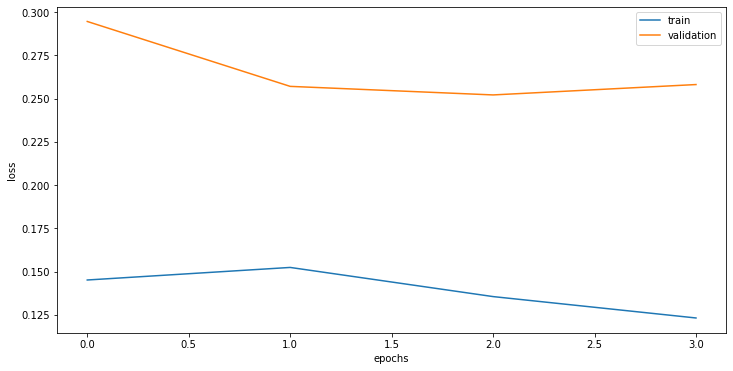

In [ ]:
fig, (ax2) = plt.subplots(1, figsize=(12, 6), sharex=True)
ax2.plot(loss_test_list, label = 'train')
ax2.set_ylabel("loss")
ax2.plot(batch_losses, label = 'validation')
plt.legend()
ax2.set_xlabel("epochs");

In [ ]:
test_images = glob.glob(os.path.join(DATA_PATH, 'train/0.jpg'))
verbose=True 
thresh=0.095
n_colors=None 
id_to_name=None
img = Image.open(np.random.choice(test_images))
img_tensor = my_transforms(img)
model.to(device)
model.eval()
with torch.no_grad():
    predictions = model([img_tensor.to(device)])
prediction = predictions[0]


In [ ]:
mask = prediction['masks'][0][0, :, :].cpu().numpy()
contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)

In [ ]:
image_1 = plt.imread(np.random.choice(test_images))

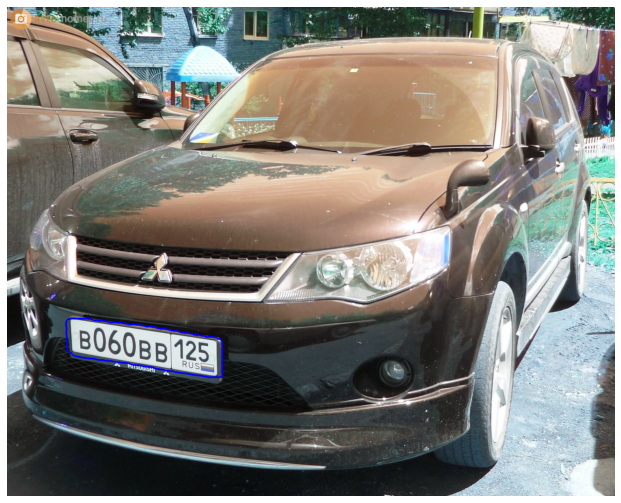

In [ ]:
cv2.drawContours( image_1, contours[0], -1, (255,0,0), 3)
show_image(image_1)

In [ ]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

In [ ]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

 54%|█████▍    | 1737/3188 [10:46<08:49,  2.74it/s]

simplify_contour didnt coverege


 64%|██████▍   | 2038/3188 [12:39<06:43,  2.85it/s]

simplify_contour didnt coverege


In [ ]:
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out

In [ ]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })

                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):

    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0,
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True 
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

2891

In [ ]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
    
        features = self.cnn(x)
        
    
        features = self.pool(features)
        
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):

        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):

        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [ ]:
crnn = CRNN()
crnn.to(device);

In [ ]:
crnn

CRNN(
  (features_extractor): FeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(

In [ ]:
SequencePredictor

__main__.SequencePredictor

In [ ]:
FeatureExtractor

__main__.FeatureExtractor

In [ ]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [ ]:
loss_test_list = np.zeros((5,))
batch_losses = np.zeros((5,))
for epoch in range(5):
    crnn.train()
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]


        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        
        loss = F.ctc_loss(
            log_probs=log_probs,  
            targets=seqs_gt,  
            input_lengths=seq_lens_pred,  
            target_lengths=seq_lens_gt 
        )  
        loss_test_list[epoch] = loss.item()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))



    for i, batch in enumerate(tqdm.tqdm(val_ocr_loader, total=len(val_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = F.ctc_loss(
            log_probs=log_probs,  
            targets=seqs_gt,  
            input_lengths=seq_lens_pred,  
            target_lengths=seq_lens_gt 
        ) 
        batch_losses[epoch] = loss.item()
        

  6%|▌         | 20/335 [00:07<02:03,  2.56it/s]

Loss: 4.9648106


 12%|█▏        | 40/335 [00:15<01:48,  2.72it/s]

Loss: 3.4998336


 18%|█▊        | 60/335 [00:22<01:48,  2.54it/s]

Loss: 3.3369781


 24%|██▍       | 80/335 [00:30<01:29,  2.84it/s]

Loss: 3.2387454


 30%|██▉       | 100/335 [00:37<01:32,  2.53it/s]

Loss: 3.1770478


 36%|███▌      | 120/335 [00:45<01:19,  2.72it/s]

Loss: 3.1123929


 42%|████▏     | 140/335 [00:52<01:14,  2.61it/s]

Loss: 3.0234656


 48%|████▊     | 160/335 [01:00<01:02,  2.79it/s]

Loss: 2.9579395


 54%|█████▎    | 180/335 [01:08<01:02,  2.48it/s]

Loss: 2.8971760


 60%|█████▉    | 200/335 [01:16<00:51,  2.64it/s]

Loss: 2.8203275


 66%|██████▌   | 220/335 [01:24<00:45,  2.55it/s]

Loss: 2.7952389


 72%|███████▏  | 240/335 [01:31<00:35,  2.65it/s]

Loss: 2.7358845


 78%|███████▊  | 260/335 [01:39<00:30,  2.49it/s]

Loss: 2.6332124


 84%|████████▎ | 280/335 [01:47<00:18,  2.95it/s]

Loss: 2.5587045


 90%|████████▉ | 300/335 [01:54<00:12,  2.84it/s]

Loss: 2.5155268


 96%|█████████▌| 320/335 [02:01<00:04,  3.06it/s]

Loss: 2.4581175


334 3.0181610591376007


  6%|▌         | 20/335 [00:07<02:04,  2.53it/s]

Loss: 2.3582000


 12%|█▏        | 40/335 [00:14<01:40,  2.92it/s]

Loss: 2.2939641


 18%|█▊        | 60/335 [00:22<01:38,  2.79it/s]

Loss: 2.2535019


 24%|██▍       | 80/335 [00:29<01:33,  2.72it/s]

Loss: 2.1803997


 30%|██▉       | 100/335 [00:36<01:26,  2.71it/s]

Loss: 2.0811591


 36%|███▌      | 120/335 [00:43<01:19,  2.72it/s]

Loss: 1.9662896


 42%|████▏     | 140/335 [00:51<01:18,  2.50it/s]

Loss: 1.9201208


 48%|████▊     | 160/335 [00:58<00:56,  3.08it/s]

Loss: 1.7447565


 54%|█████▎    | 180/335 [01:05<00:58,  2.65it/s]

Loss: 1.7216054


 60%|█████▉    | 200/335 [01:12<00:47,  2.86it/s]

Loss: 1.6581958


 66%|██████▌   | 220/335 [01:20<00:42,  2.72it/s]

Loss: 1.6755509


 72%|███████▏  | 240/335 [01:27<00:38,  2.49it/s]

Loss: 1.5921671


 78%|███████▊  | 260/335 [01:35<00:27,  2.77it/s]

Loss: 1.5766212


 84%|████████▎ | 280/335 [01:42<00:22,  2.45it/s]

Loss: 1.5200651


 90%|████████▉ | 300/335 [01:50<00:12,  2.79it/s]

Loss: 1.4580363


 96%|█████████▌| 320/335 [01:58<00:05,  2.73it/s]

Loss: 1.4004821


334 1.8157803393121976


  6%|▌         | 20/335 [00:07<01:43,  3.03it/s]

Loss: 1.2785643


 12%|█▏        | 40/335 [00:15<01:54,  2.58it/s]

Loss: 1.2826565


 18%|█▊        | 60/335 [00:22<01:42,  2.67it/s]

Loss: 1.1843233


 24%|██▍       | 80/335 [00:30<01:35,  2.68it/s]

Loss: 1.1800434


 30%|██▉       | 100/335 [00:38<01:32,  2.55it/s]

Loss: 1.1022097


 36%|███▌      | 120/335 [00:45<01:17,  2.77it/s]

Loss: 1.0237410


 42%|████▏     | 140/335 [00:54<01:14,  2.61it/s]

Loss: 1.0730064


 48%|████▊     | 160/335 [01:01<01:03,  2.77it/s]

Loss: 1.0157089


 54%|█████▎    | 180/335 [01:09<00:57,  2.70it/s]

Loss: 0.9555445


 60%|█████▉    | 200/335 [01:16<00:46,  2.92it/s]

Loss: 0.9754036


 66%|██████▌   | 220/335 [01:23<00:41,  2.76it/s]

Loss: 0.8912668


 72%|███████▏  | 240/335 [01:31<00:36,  2.61it/s]

Loss: 0.8677639


 78%|███████▊  | 260/335 [01:38<00:22,  3.26it/s]

Loss: 0.8193181


 84%|████████▎ | 280/335 [01:45<00:18,  3.03it/s]

Loss: 0.7841101


 90%|████████▉ | 300/335 [01:52<00:12,  2.74it/s]

Loss: 0.7901165


 96%|█████████▌| 320/335 [02:00<00:06,  2.36it/s]

Loss: 0.8090537


334 0.9953729620620386


  6%|▌         | 20/335 [00:07<01:54,  2.74it/s]

Loss: 0.7508267


 12%|█▏        | 40/335 [00:14<02:03,  2.40it/s]

Loss: 0.7444677


 18%|█▊        | 60/335 [00:22<01:46,  2.59it/s]

Loss: 0.7067583


 24%|██▍       | 80/335 [00:30<01:42,  2.49it/s]

Loss: 0.7103722


 30%|██▉       | 100/335 [00:37<01:31,  2.57it/s]

Loss: 0.6765218


 36%|███▌      | 120/335 [00:44<01:18,  2.74it/s]

Loss: 0.6485015


 42%|████▏     | 140/335 [00:52<01:17,  2.50it/s]

Loss: 0.6871820


 48%|████▊     | 160/335 [01:00<01:02,  2.81it/s]

Loss: 0.6203664


 54%|█████▎    | 180/335 [01:07<00:58,  2.64it/s]

Loss: 0.6104601


 60%|█████▉    | 200/335 [01:14<00:45,  2.97it/s]

Loss: 0.5927801


 66%|██████▌   | 220/335 [01:21<00:40,  2.83it/s]

Loss: 0.5369403


 72%|███████▏  | 240/335 [01:29<00:34,  2.77it/s]

Loss: 0.5854280


 78%|███████▊  | 260/335 [01:36<00:24,  3.04it/s]

Loss: 0.5032663


 84%|████████▎ | 280/335 [01:43<00:22,  2.50it/s]

Loss: 0.5460651


 90%|████████▉ | 300/335 [01:51<00:13,  2.63it/s]

Loss: 0.5078012


 96%|█████████▌| 320/335 [01:59<00:06,  2.44it/s]

Loss: 0.5180773


334 0.6164127814235972


  6%|▌         | 20/335 [00:07<01:54,  2.76it/s]

Loss: 0.4649847


 12%|█▏        | 40/335 [00:15<01:44,  2.83it/s]

Loss: 0.4087714


 18%|█▊        | 60/335 [00:22<01:38,  2.79it/s]

Loss: 0.3768622


 24%|██▍       | 80/335 [00:30<01:43,  2.46it/s]

Loss: 0.4088978


 30%|██▉       | 100/335 [00:37<01:24,  2.78it/s]

Loss: 0.3887298


 36%|███▌      | 120/335 [00:45<01:24,  2.56it/s]

Loss: 0.4227318


 42%|████▏     | 140/335 [00:52<01:11,  2.71it/s]

Loss: 0.3769857


 48%|████▊     | 160/335 [01:00<01:10,  2.46it/s]

Loss: 0.3453155


 54%|█████▎    | 180/335 [01:08<00:55,  2.80it/s]

Loss: 0.2933271


 60%|█████▉    | 200/335 [01:15<00:44,  3.00it/s]

Loss: 0.3458978


 66%|██████▌   | 220/335 [01:23<00:48,  2.39it/s]

Loss: 0.3120310


 72%|███████▏  | 240/335 [01:31<00:38,  2.46it/s]

Loss: 0.3202237


 78%|███████▊  | 260/335 [01:38<00:25,  2.92it/s]

Loss: 0.2877420


 84%|████████▎ | 280/335 [01:45<00:19,  2.86it/s]

Loss: 0.3153719


 90%|████████▉ | 300/335 [01:53<00:12,  2.74it/s]

Loss: 0.3199738


 96%|█████████▌| 320/335 [02:01<00:05,  2.53it/s]

Loss: 0.3048491


334 0.35384852837270764


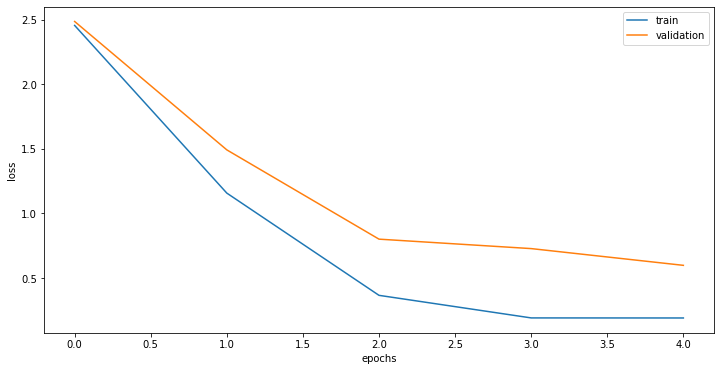

In [ ]:
fig, (ax2) = plt.subplots(1, figsize=(12, 6), sharex=True)
ax2.plot(loss_test_list, label = 'train')
ax2.set_ylabel("loss")
ax2.plot(batch_losses, label = 'validation')
plt.legend()
ax2.set_xlabel("epochs");

In [ ]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission.csv', index=False)